In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def amplitude_fn(k0,k1,x):
    return (np.cos(x+np.pi/4)**k0)*(np.sin(x+np.pi/4)**k1)

def get_amp_max(k0,k1):
    x_max_k0_k1 = 0.5*np.arcsin((k1-k0)/(k0+k1))
    amp_max = amplitude_fn(k0,k1,x_max_k0_k1)
    return amp_max

def norm_amplitude_fn(k0,k1,x):
    amp_max = get_amp_max(k0,k1)
    return amplitude_fn(k0,k1,x)/amp_max

def expo(k0,k1,x):
    return np.exp(-x*(k0-k1))/get_amp_max(k0,k1)

In [3]:
x = np.arange(-np.pi/4, np.pi/4, 0.01)

In [4]:
k0, k1 = 50, 0
values_1 = norm_amplitude_fn(k0,k1,x)
exp_values_1 = expo(k0,k1,x)

k0, k1 = 30, 20
values_2 = norm_amplitude_fn(k0,k1,x)
exp_values_2 = expo(k0,k1,x)

k0, k1 = 5, 45
values_3 = norm_amplitude_fn(k0,k1,x)
exp_values_3 = expo(k0,k1,x)

(0.0, 1.1)

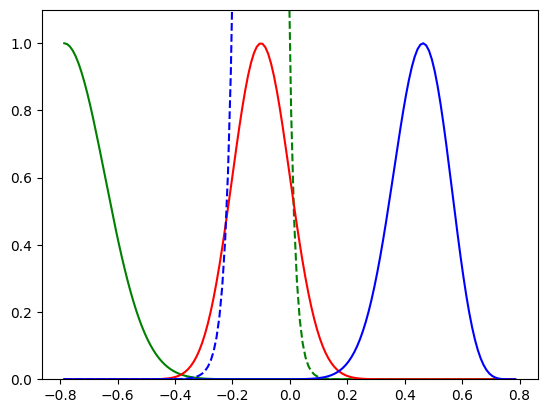

In [5]:
plt.plot(x,values_1,'g')
plt.plot(x,exp_values_1,'g--')

plt.plot(x,values_2,'r')
plt.plot(x,exp_values_2,'r--')

plt.plot(x,values_3,'b')
plt.plot(x,exp_values_3,'b--')

plt.ylim(0,1.1)

In [6]:
k0, k1 = 500, 0
values_1 = norm_amplitude_fn(k0,k1,x)
exp_values_1 = expo(k0,k1,x)

k0, k1 = 300, 200
values_2 = norm_amplitude_fn(k0,k1,x)
exp_values_2 = expo(k0,k1,x)

k0, k1 = 50, 450
values_3 = norm_amplitude_fn(k0,k1,x)
exp_values_3 = expo(k0,k1,x)

(0.0, 1.1)

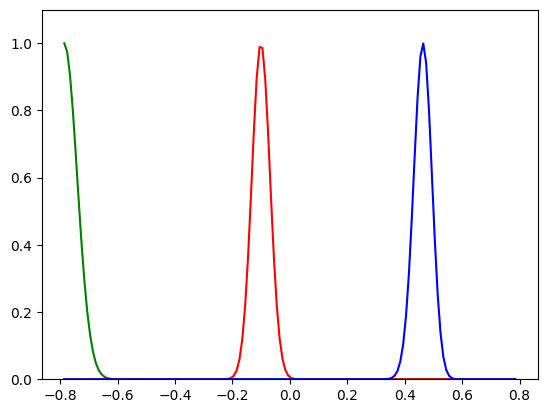

In [7]:
plt.plot(x,values_1,'g')

plt.plot(x,values_2,'r')

plt.plot(x,values_3,'b')

plt.ylim(0,1.1)

In [8]:
from qiskit import *
from qiskit.quantum_info import SparsePauliOp
from qiskit.opflow.primitive_ops import PauliSumOp
from qiskit.opflow import PauliTrotterEvolution
from qiskit.opflow.evolutions import Suzuki
from qiskit.circuit import Parameter
from qiskit.primitives import Sampler
from qiskit import Aer

In [9]:
def compute_U_trot(H, time, trotter_steps, order=1):
    """
    Apply the Suzuki-Trotter approximation to the Hamiltonian H to 
    compute a trotterized unitary time evolution operator.

    """

    U_trot = Suzuki(trotter_steps, order=order).convert(time * H)
    return U_trot

In [10]:
def convert_U_trot_to_qc(U_trot):
    """
    Convert the U_trot ComposedOp object returned by compute_U_trot() to a bare quantum circuit.
    """

    qc_trot = PauliTrotterEvolution().convert(U_trot)
    return (
        qc_trot.to_circuit().decompose().decompose()
    )  # add decompose methods so gates are not abstracted unitary blocks

In [12]:
H = PauliSumOp(SparsePauliOp(["YZ",],[1]))

time_param = Parameter("t")
epsilon = 0.2

## No trotterization

In [13]:
evolution_op = (time_param*H).exp_i()
print(evolution_op) 

e^(-i*1.0*t * (
  1.0 * YZ
))


e^(-i*0.2 * (
  1.0 * YZ
))


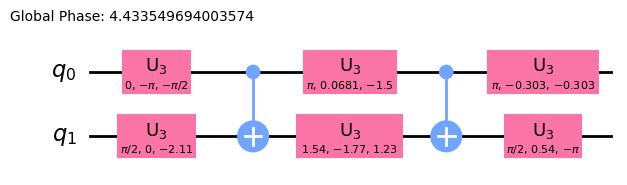

In [14]:
evop = evolution_op.assign_parameters({time_param: epsilon})
print(evop)

qc_bound = evop.to_circuit()
qc_bound.draw('mpl')

In [15]:
t = 100

qr = QuantumRegister(2)
cr = ClassicalRegister(2, name="ancilla_reg")

qc = QuantumCircuit(qr,cr)
qc.h(0)

for i in range(t):
    qc.h(1)
    qc.compose(qc_bound, [0,1], inplace=True)
    qc.measure([1],cr[1])
    
    with qc.if_test((cr[1],1)):
        qc.x(0)
    qc.reset(1)

qc.measure([0,1], cr)

In [16]:
shots = 1024
backend_sim = Aer.get_backend("aer_simulator")
job = backend_sim.run(qc, shots = shots)
result = job.result()
counts = result.get_counts()
counts = {i: j/shots for i,j in counts.items()}
print(counts)
print(counts['01'])

{'00': 0.2919921875, '01': 0.7080078125}
0.7080078125


## Trotterization

In [17]:
trotter_steps = 1

# Compute unitary time operator
U_trot_params = compute_U_trot(H, time_param, int(trotter_steps))

print(U_trot_params)

# Convert to trotterized unitary to circuit
qc_trot = convert_U_trot_to_qc(U_trot_params)

# bind parameters
qc_bound = qc_trot.bind_parameters({time_param: np.sqrt(epsilon)})

e^(-i*1.0*t**2 * (
  1.0 * YZ
))


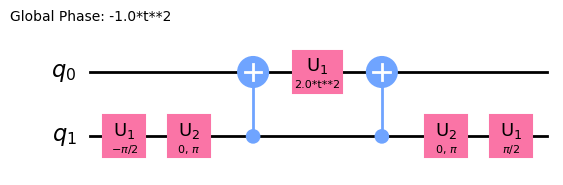

In [18]:
qc_trot.draw('mpl')

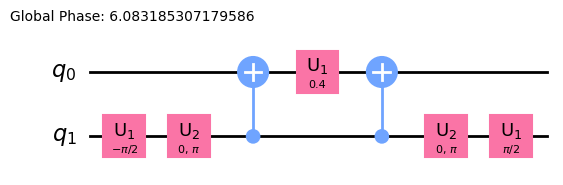

In [19]:
qc_bound.draw('mpl')

In [20]:
t = 100

qr = QuantumRegister(2)
cr = ClassicalRegister(2, name="ancilla_reg")

qc = QuantumCircuit(qr,cr)
qc.h(0)

for i in range(t):
    qc.h(1)
    qc.compose(qc_bound, [0,1], inplace=True)
    qc.measure([1],cr[1])
    
    with qc.if_test((cr[1],1)):
        qc.x(0)
    qc.reset(1)

qc.measure([0,1], cr)

In [21]:
shots = 1024
backend_sim = Aer.get_backend("aer_simulator")
job = backend_sim.run(qc, shots = shots)
result = job.result()
counts = result.get_counts()
counts = {i: j/shots for i,j in counts.items()}
print(counts)
print(counts['01'])

{'00': 0.3154296875, '01': 0.6845703125}
0.6845703125
